In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
import pandas as pd
import random
import torch
import time
import numpy as np
from gensim.models.word2vec import Word2Vec
from model import BatchProgramClassifier
from torch.autograd import Variable
from torch.utils.data import DataLoader

import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable

import re

from pycparser.c_ast import TypeDecl, ArrayDecl
from pycparser import c_ast

In [2]:
root = '/home/david/projects/university/astnn/data/'

word2vec = Word2Vec.load(root+"train/embedding/node_w2v_128").wv
embeddings = np.zeros((word2vec.vectors.shape[0] + 1, word2vec.vectors.shape[1]), dtype="float32")
embeddings[:word2vec.vectors.shape[0]] = word2vec.vectors

HIDDEN_DIM = 100
ENCODE_DIM = 128
LABELS = 104
EPOCHS = 15
BATCH_SIZE = 1
USE_GPU = False
MAX_TOKENS = word2vec.vectors.shape[0]
EMBEDDING_DIM = word2vec.vectors.shape[1]

model = BatchProgramClassifier(EMBEDDING_DIM,HIDDEN_DIM,MAX_TOKENS+1,ENCODE_DIM,LABELS,BATCH_SIZE,
                               USE_GPU, embeddings)
model.load_state_dict(torch.load("/home/david/projects/university/astnn/model.pt"))

<All keys matched successfully>

# Load Data

In [3]:
word2vec = Word2Vec.load('/home/david/projects/university/astnn/data/train/embedding/node_w2v_128').wv
vocab = word2vec.vocab

ast_data = pd.read_pickle(root+'test/test_.pkl')
block_data = pd.read_pickle(root+'test/blocks.pkl')

# Allowed var names

In [4]:
leaf_embed = nn.Sequential(
    model._modules['encoder']._modules['embedding'],
    model._modules['encoder']._modules['W_c']
)

In [5]:
# words we wont allow as variable names
reserved_words = [
    'auto',
    'break',
    'case',
    'char',
    'const',
    'continue',
    'default',
    'do',
    'int',
    'long',
    'register',
    'return',
    'short',
    'sizeof',
    'static',
    'struct',
    'switch',
    'typedef',
    'union',
    'unsigned',
    'void',
    'volatile',
    'while',
    'double',
    'else',
    'enum',
    'extern',
    'float',
    'for',
    'goto',
    'if',
    'printf',
    'scanf',
    'cos',
    'malloc'
]


def allowed_variable(var):
    pattern = re.compile("([a-z]|[A-Z]|_)+([a-z]|[A-Z]|[0-9]|_)*$")
    if (var not in reserved_words) and pattern.match(var):
        return True
    else:
        return False

allowed_variable('scanf')

False

In [6]:
embedding_map = {}

for index in range(len(vocab)):
    if allowed_variable(word2vec.index2word[index]):
        embedding_map[index] = leaf_embed(torch.tensor(index)).detach().numpy()

# Var replace functions

In [7]:
def replace_index(node, old_i, new_i):
    i = node[0]
    if i == old_i:
        result = [new_i]
    else:
        result = [i]
    children = node[1:]
    for child in children:
        result.append(replace_index(child, old_i, new_i))
    return result

def replace_var(x, old_i, new_i):
    mod_blocks = []
    for block in x:
        mod_blocks.append(replace_index(block, old_i, new_i))

    return mod_blocks

# Closest Var functions

In [8]:
def l2_norm(a, b):
    return np.linalg.norm(a-b)

def cos_sim(a, b):
    return np.inner(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

def closest_index(embedding, embedding_map, metric):
    embedding = embedding.detach().numpy()
    closest_i = list(embedding_map.keys())[0]
    closest_dist = metric(embedding_map[closest_i], embedding)
    for i, e in embedding_map.items():
        d = metric(embedding_map[i], embedding)
        if d < closest_dist:
            closest_dist = d
            closest_i = i
    return closest_i

def normalize(v):
    norm = np.linalg.norm(v)
    if norm == 0:
        return v
    return v / norm

# Grad locating functions

In [9]:
def get_embedding(indices, node_list):
    '''
    get the embeddings at the index positions in postorder traversal.
    '''
    res = []
    c = 0
    for i in range(node_list.size(0)):
        if not np.all(node_list[i].detach().numpy() == 0):
            if c in indices:
                res.append(node_list[i])
            c += 1
    return res

def post_order_loc(node, var, res, counter):
    '''
    
    '''
    index = node[0]
    children = node[1:]
    for child in children:
        res, counter = post_order_loc(child, var, res, counter)
    if var == index and (not children):
        res.append(counter) 
#         print(counter, word2vec.index2word[index])
    counter += 1
    return res, counter

def get_grad(x, var_index, node_list):
    grads = []
    for i, block in enumerate(x):
        indices, _ = post_order_loc(block, var_index, [], 0)
        grads += get_embedding(indices, node_list.grad[:, i, :])
        try:
            node_embedding = get_embedding(indices, node_list[:, i, :])[0]
        except:
            pass
        
    if len(grads) < 1:
        return None, None
    grad = torch.stack(grads).sum(dim=0)
    return grad, node_embedding

# Var name finder

In [10]:

class declarationFinder(c_ast.NodeVisitor):
    def __init__(self):
        self.names = set()
    
    def visit_Decl(self, node):
        if type(node.type) in [TypeDecl, ArrayDecl] :
            self.names.add(node.name)

def get_var_names(ast):
    declaration_finder = declarationFinder()
    declaration_finder.visit(ast)
    return declaration_finder.names
    
# get_var_names(x)

# FGSM

with vars ordered and early exit

In [11]:
# def gradient_method(x, n_list, var, epsilon, metric):

#     orig_index = vocab[var].index if var in vocab else MAX_TOKEN

#     grad, node_embedding = get_grad(x, orig_index, n_list)
#     if grad is None:
# #         print("no leaf occurences")
#         return None

#     v = node_embedding.detach().numpy()
#     g = torch.sign(grad).detach().numpy()
    

#     v = v + epsilon * g
#     # get the closest emebedding from our map
#     i = closest_index(v, sampled_embedding_map, metric)
# #         print("orig name:", word2vec.index2word[orig_index], "; new name:", word2vec.index2word[i])
#     if i != orig_index:
#         return replace_var(x, orig_index, i)
#     else:
#         return x

In [12]:
MAX_TOKEN = word2vec.vectors.shape[0]

In [26]:
import time
import datetime

success_stats = []

def evaluate(epsilon, limit = None, sort_vars = True):
    ast_count = 0
    var_count = 0

    ast_total = 0
    var_total = 0

    start = time.time()
    for code_id in block_data['id'].tolist():
    #     print(code_id)
        x, ast = block_data['code'][code_id], ast_data['code'][code_id]

        _, orig_pred = torch.max(model([x]).data, 1)
        orig_pred = orig_pred.item()

        # get the grad
        loss_function = torch.nn.CrossEntropyLoss()
        labels = torch.LongTensor([orig_pred])
        output = model([x])
        loss = loss_function(output, Variable(labels))
        loss.backward()
        n_list = model._modules['encoder'].node_list

        var_names = get_var_names(ast)
        success = False
        
        var_weighted = []
        for var in list(var_names):
            
            orig_index = vocab[var].index if var in vocab else MAX_TOKEN
            grad, node_embedding = get_grad(x, orig_index, n_list)
            if grad is not None:
                # l1
                h = abs((grad @ torch.sign(grad)).item())
                # l2
                var_weighted.append( (h, grad, node_embedding) )
            
        if sort_vars:
            var_weighted = sorted(var_weighted, key=lambda x: x[0], reverse = True)
        
        var_count=0
        
        depth = 2
        var_index = 0
                    
        
        for h, grad, node_embedding in var_weighted:
            
            v = node_embedding
            g = torch.sign(grad)

            v = v + epsilon * g
            # get the closest emebedding from our map
            i = closest_index(v, sampled_embedding_map, l2_norm)
            if i != orig_index:
                new_x_l2 = replace_var(x, orig_index, i)
            else:
                new_x_l2 = x
            
            if new_x_l2:
                o = model([new_x_l2])
                _, predicted_l2 = torch.max(o.data, 1)

    #             print(orig_pred, predicted_l2.item())
                var_total += 1
                if orig_pred != predicted_l2.item():
                    var_count += 1
                    success = True
                    success_stats.append((False, h, var_count))
                else:
                    success_stats.append((True, h, var_count))
                    
            var_count += 1
                    

        if success:
            ast_count += 1
        ast_total += 1


        if ast_total % 500 == 499:
            eval_time = time.time() - start
            eval_time = datetime.timedelta(seconds=eval_time)
            print(ast_total, ";", eval_time, ";", ast_count / ast_total, ";", var_count / var_total)
    
        if limit and limit < ast_total:
            break
    return (ast_count / ast_total, var_count / var_total)


In [27]:
# sample_rate = 0.2
# sample_count = int(len(embedding_map) * sample_rate)
# sampled_embedding_map = {key: embedding_map[key] for key in random.sample(embedding_map.keys(), sample_count)}

sampled_embedding_map = embedding_map

In [28]:
success_stats = []
evaluate(40)

499 ; 0:03:47.109363 ; 0.2985971943887776 ; 0.002499218994064355
999 ; 0:07:32.133515 ; 0.2902902902902903 ; 0.001549666821633349
1499 ; 0:11:31.158948 ; 0.2781854569713142 ; 0.000307723869114781
1999 ; 0:15:37.358090 ; 0.2861430715357679 ; 0.00038162112654556554
2499 ; 0:19:22.698368 ; 0.2805122048819528 ; 0.0006702821278410822
2999 ; 0:23:35.367039 ; 0.2784261420473491 ; 0.00020340706839562674
3499 ; 0:27:19.991438 ; 0.27807945127179196 ; 0.0004378667133724494
3999 ; 0:31:25.168175 ; 0.27556889222305575 ; 0.0001911826559094559
4499 ; 0:35:07.867343 ; 0.2800622360524561 ; 0.00017046810541747638
4999 ; 0:39:25.619583 ; 0.28005601120224044 ; 0.00024458847988259754
5499 ; 0:43:22.313887 ; 0.28132387706855794 ; 0.0002779167361458507
5999 ; 0:47:27.385960 ; 0.28271378563093846 ; 0.00017856231824906892
6499 ; 0:51:32.340820 ; 0.28250500076934915 ; 0.00011767751653369107
6999 ; 0:55:48.407651 ; 0.2797542506072296 ; 0.00015286179110344375
7499 ; 1:00:31.310111 ; 0.28230430724096545 ; 0.000163

(0.28429958657821364, 0.00014734267485891938)

In [60]:
success_df = pd.DataFrame(success_stats, columns=["robustness", "heuristic", "position"])

In [61]:
success_df

,robustness,heuristic,position
0,True,0.016910,0
1,True,0.008668,1
2,True,0.008204,2
3,True,0.002410,3
4,True,0.001941,4
...,...,...,...
67864,True,1.607269,2
67865,False,1.213506,4
67866,True,0.761030,5
67867,False,0.483132,7


array([[<AxesSubplot:title={'center':'heuristic'}>]], dtype=object)

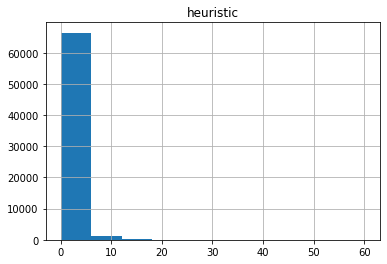

In [62]:
success_df.hist("heuristic")
# success_df.hist("heuristic", by="success", sharex=True)

In [63]:
success_df.groupby(pd.cut(success_df["heuristic"], bins=10)).count()

,robustness,heuristic,position
heuristic,,,
"(-0.0602, 6.019]",66443,66443,66443
"(6.019, 12.038]",1067,1067,1067
"(12.038, 18.057]",251,251,251
"(18.057, 24.077]",67,67,67
"(24.077, 30.096]",27,27,27
"(30.096, 36.115]",8,8,8
"(36.115, 42.134]",2,2,2
"(42.134, 48.153]",3,3,3
"(48.153, 54.172]",0,0,0


                   robustness  heuristic  position
heuristic                                         
(-0.00998, 0.998]       60045      60045     60045
(0.998, 1.997]           3000       3000      3000
(1.997, 2.995]           1436       1436      1436
(2.995, 3.993]            924        924       924
(3.993, 4.991]            590        590       590
(4.991, 5.99]             437        437       437
(5.99, 6.988]             297        297       297
(6.988, 7.986]            238        238       238
(7.986, 8.984]            154        154       154
(8.984, 9.983]            161        161       161


<AxesSubplot:title={'center':'Robustness by Heuristic'}, xlabel='heuristic'>

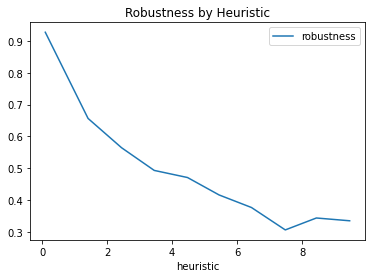

In [70]:
filtered = success_df[success_df["heuristic"]<10]
binned = filtered.groupby(pd.cut(filtered["heuristic"], bins=10))
print(binned.count())
binned.mean().plot.line("heuristic", "robustness", title="Robustness by Heuristic")

                  robustness  heuristic  position
heuristic                                        
(-0.0198, 0.992]       60012      60012     60012
(0.992, 1.984]          3005       3005      3005
(1.984, 2.976]          1441       1441      1441
(2.976, 3.968]           932        932       932
(3.968, 4.959]           588        588       588
(4.959, 5.951]           448        448       448
(5.951, 6.943]           290        290       290
(6.943, 7.935]           237        237       237
(7.935, 8.927]           161        161       161
(8.927, 9.919]           160        160       160
(9.919, 10.911]          133        133       133
(10.911, 11.903]          91         91        91
(11.903, 12.894]          78         78        78
(12.894, 13.886]          47         47        47
(13.886, 14.878]          43         43        43
(14.878, 15.87]           39         39        39
(15.87, 16.862]           25         25        25
(16.862, 17.854]          30         30        30


<AxesSubplot:title={'center':'Robustness by Heuristic'}, xlabel='heuristic'>

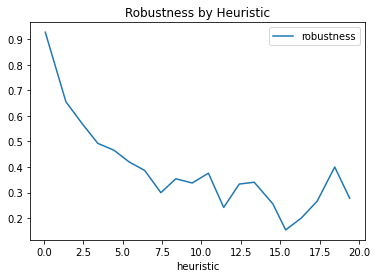

In [68]:
filtered = success_df[success_df["heuristic"]<20]
binned = filtered.groupby(pd.cut(filtered["heuristic"], bins=20))
print(binned.count())
binned.mean().plot.line("heuristic", "robustness", title="Robustness by Heuristic")

                  robustness  heuristic  position
heuristic                                        
(-0.0295, 0.983]       59966      59966     59966
(0.983, 1.965]          3011       3011      3011
(1.965, 2.948]          1458       1458      1458
(2.948, 3.93]            924        924       924
(3.93, 4.913]            597        597       597
(4.913, 5.895]           449        449       449
(5.895, 6.878]           295        295       295
(6.878, 7.86]            236        236       236
(7.86, 8.843]            170        170       170
(8.843, 9.825]           155        155       155
(9.825, 10.808]          132        132       132
(10.808, 11.79]           93         93        93
(11.79, 12.773]           84         84        84
(12.773, 13.755]          47         47        47
(13.755, 14.738]          38         38        38
(14.738, 15.72]           48         48        48
(15.72, 16.703]           25         25        25
(16.703, 17.685]          26         26        26


<AxesSubplot:title={'center':'Robustness by Heuristic'}, xlabel='heuristic'>

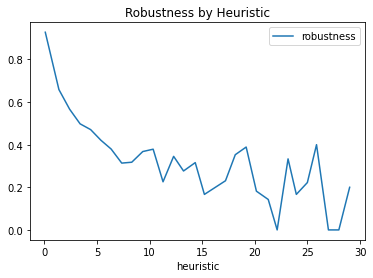

In [74]:
filtered = success_df[success_df["heuristic"]<30]
binned = filtered.groupby(pd.cut(filtered["heuristic"], bins=30))
print(binned.count())
binned.mean().plot.line("heuristic", "robustness", title="Robustness by Heuristic")

                  robustness  heuristic  position
heuristic                                        
(-0.0374, 0.935]       59742      59742     59742
(0.935, 1.869]          3052       3052      3052
(1.869, 2.804]          1483       1483      1483
(2.804, 3.739]           938        938       938
(3.739, 4.673]           597        597       597
(4.673, 5.608]           478        478       478
(5.608, 6.543]           333        333       333
(6.543, 7.477]           220        220       220
(7.477, 8.412]           205        205       205
(8.412, 9.347]           134        134       134
(9.347, 10.281]          135        135       135
(10.281, 11.216]         119        119       119
(11.216, 12.151]          80         80        80
(12.151, 13.085]          69         69        69
(13.085, 14.02]           41         41        41
(14.02, 14.955]           42         42        42
(14.955, 15.889]          37         37        37
(15.889, 16.824]          24         24        24


<AxesSubplot:title={'center':'Robustness by Heuristic'}, xlabel='heuristic'>

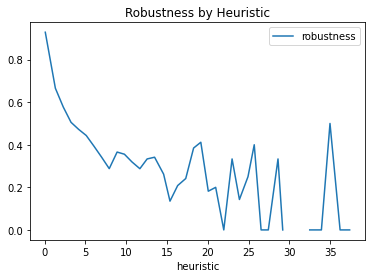

In [75]:
filtered = success_df[success_df["heuristic"]<40]
binned = filtered.groupby(pd.cut(filtered["heuristic"], bins=40))
print(binned.count())
binned.mean().plot.line("heuristic", "robustness", title="Robustness by Heuristic")

In [58]:
binned.count()

,robust,heuristic,position
heuristic,,,
"(-0.00998, 0.998]",60045,60045,60045
"(0.998, 1.997]",3000,3000,3000
"(1.997, 2.995]",1436,1436,1436
"(2.995, 3.993]",924,924,924
"(3.993, 4.991]",590,590,590
"(4.991, 5.99]",437,437,437
"(5.99, 6.988]",297,297,297
"(6.988, 7.986]",238,238,238
"(7.986, 8.984]",154,154,154


In [45]:
success_df.groupby(success_df["position"]).mean()

,success,heuristic
position,,
0,0.000000,0.618689
1,0.173820,1.216964
2,0.057348,0.455509
3,0.134571,0.741115
4,0.076190,0.311906
5,0.157975,0.544603
6,0.110220,0.311196
7,0.170732,0.555716
8,0.157676,0.322255


In [29]:
pd.cut(success_df["heuristic"], bins=10)

0       (-0.0255, 2.547]
1       (-0.0255, 2.547]
2       (-0.0255, 2.547]
3       (-0.0255, 2.547]
4       (-0.0255, 2.547]
              ...       
1325    (-0.0255, 2.547]
1326    (-0.0255, 2.547]
1327    (-0.0255, 2.547]
1328    (-0.0255, 2.547]
1329    (-0.0255, 2.547]
Name: heuristic, Length: 1330, dtype: category
Categories (10, interval[float64]): [(-0.0255, 2.547] < (2.547, 5.094] < (5.094, 7.641] < (7.641, 10.187] ... (15.281, 17.828] < (17.828, 20.375] < (20.375, 22.922] < (22.922, 25.468]]

In [1]:
def ci(x, z, n):
    r = z * ( (x * (1 - x)) / n)**0.5
    return round(x, 3), round(r, 3), round(x-r, 3), round(x+r, 3)

print(ci(0.927271, 1.96, 60045))
print(ci(0.656667, 1.96, 3000))
print(ci(0.564763, 1.96, 1436))
print(ci(0.493506, 1.96, 924))
print(ci(0.471186, 1.96, 590))
print(ci(0.416476, 1.96, 437))
print(ci(0.377104, 1.96, 297))
print(ci(0.306723, 1.96, 238))
print(ci(0.344156, 1.96, 154))
print(ci(0.335404, 1.96, 161))

(0.927, 0.002, 0.925, 0.929)
(0.657, 0.017, 0.64, 0.674)
(0.565, 0.026, 0.539, 0.59)
(0.494, 0.032, 0.461, 0.526)
(0.471, 0.04, 0.431, 0.511)
(0.416, 0.046, 0.37, 0.463)
(0.377, 0.055, 0.322, 0.432)
(0.307, 0.059, 0.248, 0.365)
(0.344, 0.075, 0.269, 0.419)
(0.335, 0.073, 0.262, 0.408)
